In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization

import os
import cv2
import glob
import pickle
import random
import warnings

In [2]:
batch_size = 32
img_height = 128
img_width = 128
epochs = 30
num_classes = 27
img_channels = 3

In [3]:
main_folder_path = r"D:\aslaplhabets\asl_alphabet_train\asl_alphabet_train"
subfolders = os.listdir(main_folder_path)

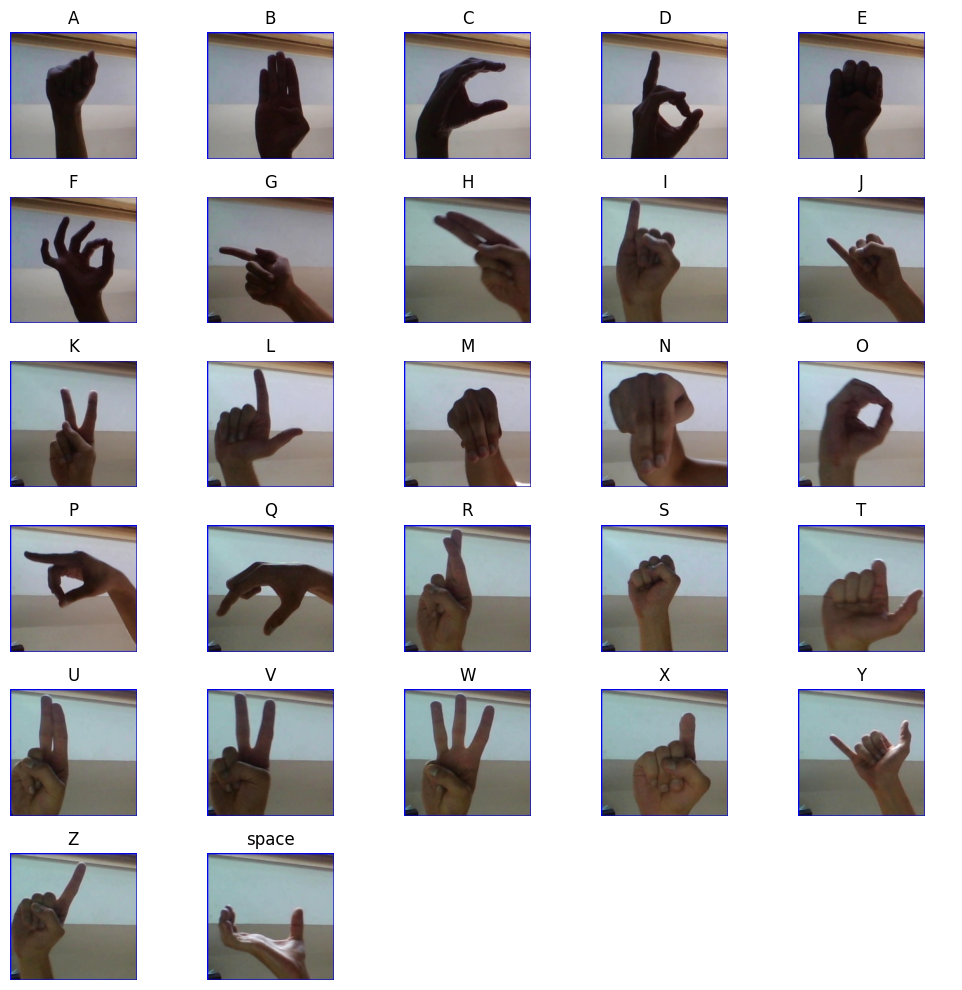

In [4]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

In [ ]:
for index, subfolder in enumerate(sorted(subfolder)): 
    categories[index] = subfolder

    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_file

In [5]:
df['Count'].min(), df['Count'].max()


(3000, 3000)

In [6]:
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframe["image_path"],dataframe["label"],test_size=0.15,random_state=2024,shuffle=True,stratify = dataframe["label"])

train_df = pd.DataFrame({"image_path": X_train,"label": y_train})

X_train, X_val, y_train, y_val = train_test_split(train_df["image_path"], train_df["label"],test_size=0.20,random_state=2024,shuffle=True,stratify=train_df["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [ ]:
datagen = image.ImageDataGenerator(rescale=1/255.,)
# Training Dataset
train_gen = datagen.flow_from_dataframe(train_df,directory="./",x_col="image_path",y_col="label",class_mode="categorical",batch_size=batch_size,target_size=(img_height, img_width),)

# Validation Dataset
val_gen = datagen.flow_from_dataframe(val_df,directory="./",x_col="image_path",y_col="label",class_mode="categorical",batch_size=batch_size,target_size=(img_height, img_width),)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(test_df,directory="./",x_col="image_path",y_col="label",class_mode="categorical",batch_size=1,target_size=(img_height, img_width),shuffle=False)

Found 55080 validated image filenames belonging to 27 classes.
Found 13770 validated image filenames belonging to 27 classes.
Found 12150 validated image filenames belonging to 27 classes.


In [9]:
image_shape = (128, 128, 3)
print(200*200*3)
print(128*128*3)

120000
49152


In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [12]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (5, 5), input_shape=image_shape)) ##32 filters, 5x5 kernel, input shape is 128x128x3
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Flatten()) ##flatten the data
cnn_model.add(Dense(128, activation='relu')) ##128 neurons, activation function
cnn_model.add(Dense(27, activation='softmax')) ##output layer, 27 neurons, activation function

display(cnn_model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 activation_3 (Activation)   (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 60, 60, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  

None

In [13]:
# Compile and train the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
cnn_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

Epoch 1/30
1721/1721 [==============================] - 566s 326ms/step - loss: 0.8913 - accuracy: 0.7286 - val_loss: 0.2003 - val_accuracy: 0.9347 - lr: 0.0010
Epoch 2/30
1721/1721 [==============================] - 509s 295ms/step - loss: 0.1136 - accuracy: 0.9633 - val_loss: 0.0592 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 3/30
1721/1721 [==============================] - 169s 98ms/step - loss: 0.0631 - accuracy: 0.9796 - val_loss: 0.1012 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 4/30
1721/1721 [==============================] - 83s 49ms/step - loss: 0.0502 - accuracy: 0.9842 - val_loss: 0.0555 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/30
1721/1721 [==============================] - 87s 51ms/step - loss: 0.0382 - accuracy: 0.9884 - val_loss: 0.0577 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 6/30
1720/1721 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9895
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1721/1721 [===============

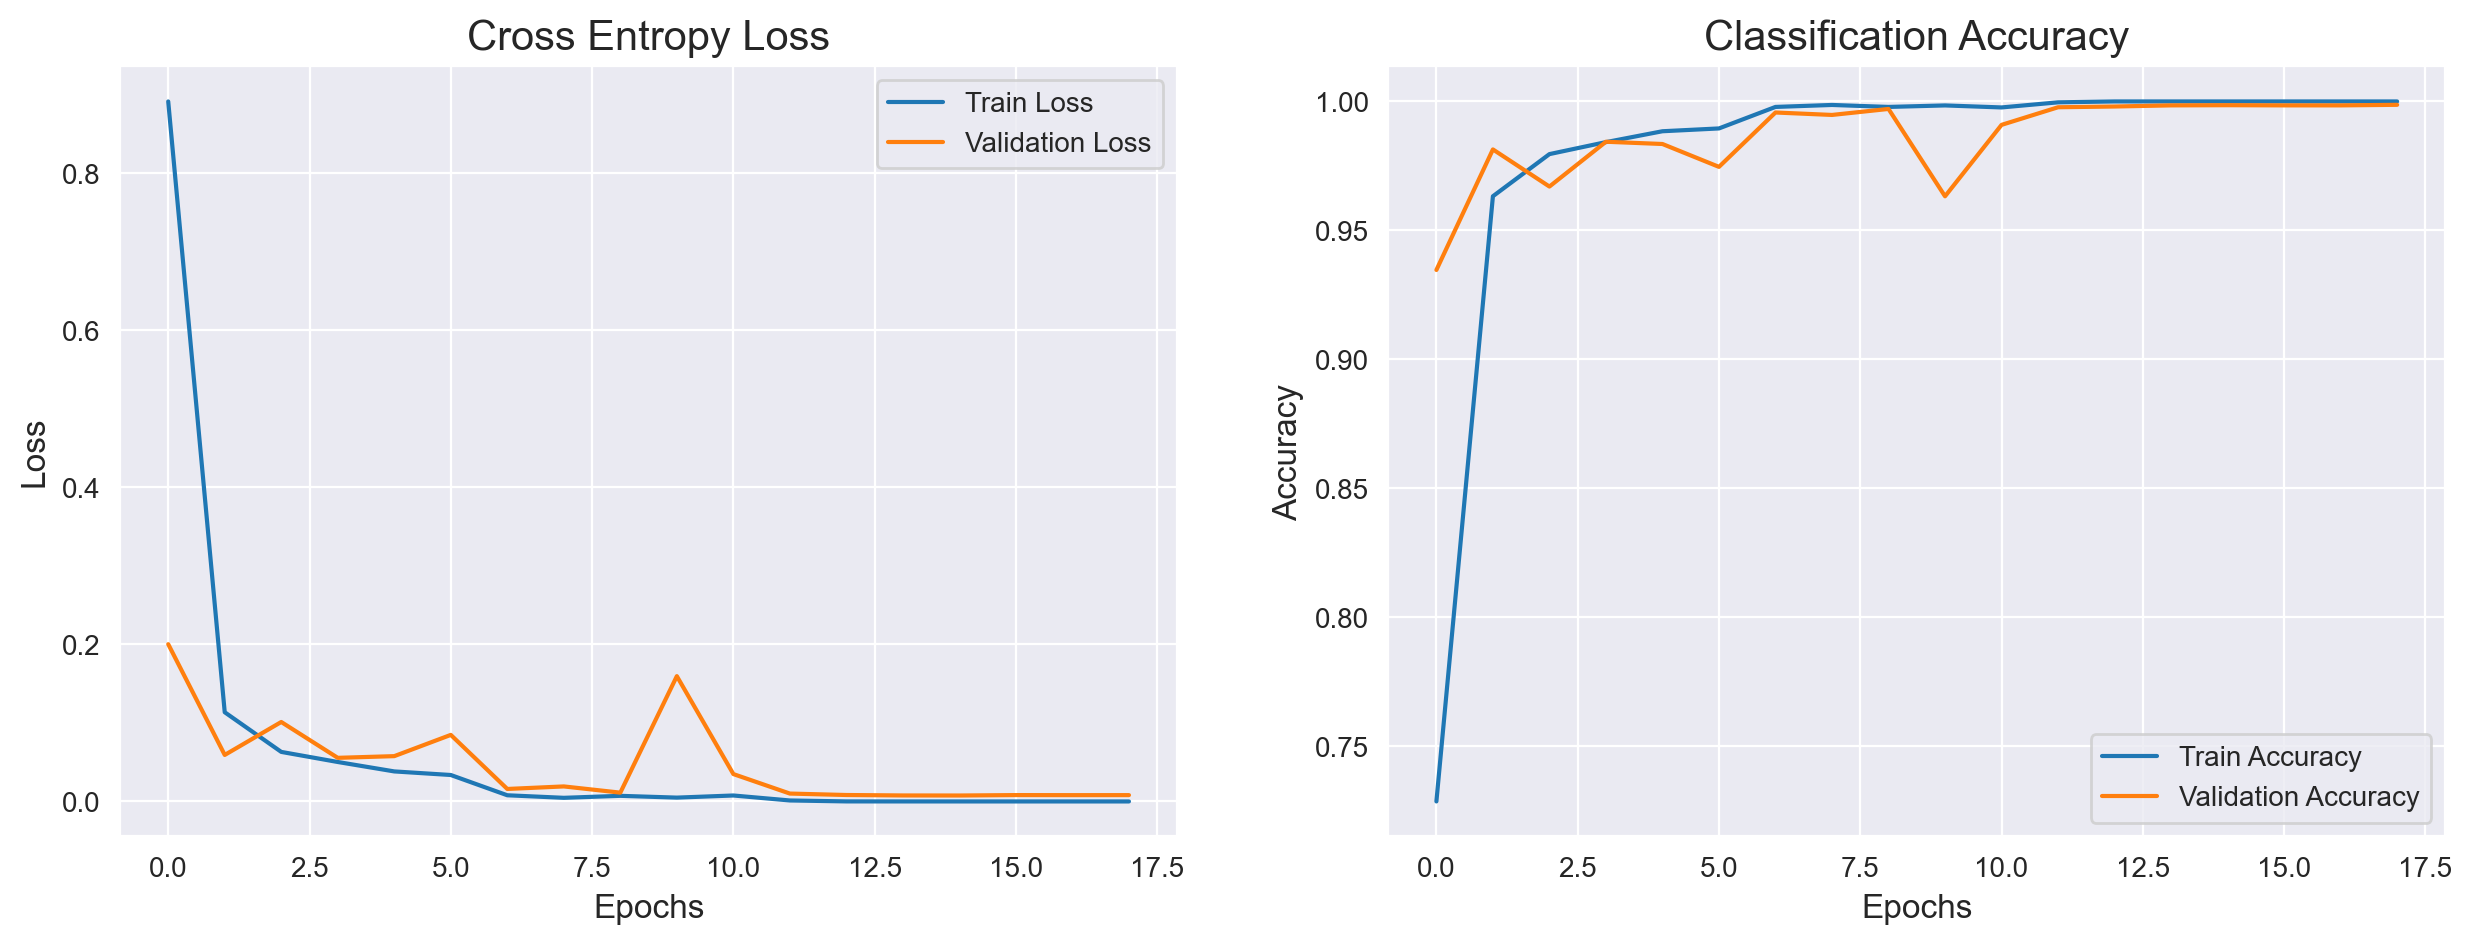

In [14]:
metrics = pd.DataFrame(cnn_model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [16]:
cnn_model.save('cnn_model.h5')

In [18]:
predicted_class = cnn_model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 12127
Incorrect predicted classes: 23


In [19]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       0.99      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      0.99      0.99       450
           O       1.00      1.00      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       1.00    

In [20]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

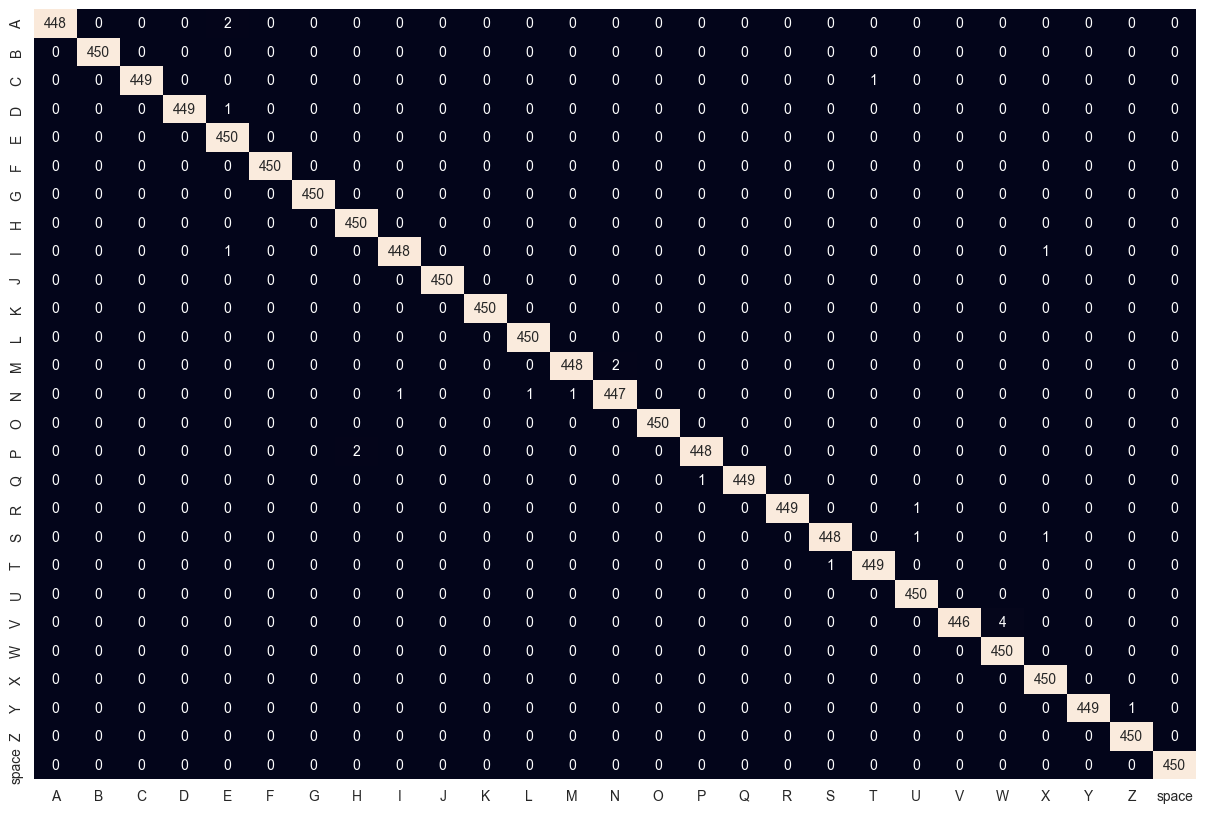

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

In [25]:
test_images = r"D:\aslaplhabets\asl_alphabet_test\asl_alphabet_test"

for i in os.listdir(test_images):
  img = os.path.join(test_images, i)
  print(f'Image: {i}', end='\t\t')
  img = cv2.imread(img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (128, 128))

  img = image.img_to_array(img)

  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  predict = cnn_model.predict(img, verbose=False)
  predict_class = np.argmax(predict, axis=1)

  print("Prediction: ", categories[tuple(predict_class)[0]], end='\n\n')


Image: A_test.jpg		Prediction:  A

Image: B_test.jpg		Prediction:  B

Image: C_test.jpg		Prediction:  C

Image: D_test.jpg		Prediction:  D

Image: E_test.jpg		Prediction:  E

Image: F_test.jpg		Prediction:  F

Image: G_test.jpg		Prediction:  G

Image: H_test.jpg		Prediction:  O

Image: I_test.jpg		Prediction:  space

Image: J_test.jpg		Prediction:  P

Image: K_test.jpg		Prediction:  K

Image: L_test.jpg		Prediction:  L

Image: M_test.jpg		Prediction:  N

Image: nothing_test.jpg		Prediction:  D

Image: N_test.jpg		Prediction:  N

Image: O_test.jpg		Prediction:  O

Image: P_test.jpg		Prediction:  P

Image: Q_test.jpg		Prediction:  Q

Image: R_test.jpg		Prediction:  R

Image: space_test.jpg		Prediction:  space

Image: S_test.jpg		Prediction:  S

Image: T_test.jpg		Prediction:  T

Image: U_test.jpg		Prediction:  U

Image: V_test.jpg		Prediction:  W

Image: W_test.jpg		Prediction:  W

Image: X_test.jpg		Prediction:  T

Image: Y_test.jpg		Prediction:  Y

Image: Z_test.jpg		Prediction:  O



In [26]:
fine_tuned_model = load_model(r"D:\aslaplhabets\weights\best_weights.h5")

In [27]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [28]:
def dense_feature_prediction(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = test_df[test_df["label"]==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

C:\Users\krita\AppData\Local\Temp\ipykernel_4072\1124270408.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
C:\Users\krita\AppData\Local\Temp\ipykernel_4072\1124270408.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
C:\Users\krita\AppData\Local\Temp\ipykernel_4072\1124270408.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(label_data)
C:\Users\krita\AppData\Local\Temp\ipykernel_4072\1124270408.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduction_data = reduction_data.append(

,image_path,label
0,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A
1,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A
2,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A
3,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A
4,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A
...,...,...
2695,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space
2696,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space
2697,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space
2698,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space


In [29]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.017s...
[t-SNE] Computed neighbors for 2700 samples in 0.880s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 4.233543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.422558
[t-SNE] KL divergence after 1000 iterations: 0.474404


,image_path,label,tsne_feat_0,tsne_feat_1
0,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A,-18.459053,18.776890
1,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A,-18.217247,21.907272
2,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A,-18.950825,20.821768
3,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A,-17.732218,14.093944
4,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,A,-18.296480,19.112947
...,...,...,...,...
2695,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space,9.056046,-26.026861
2696,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space,9.472390,-23.732107
2697,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space,9.365949,-26.539923
2698,D:\aslaplhabets\asl_alphabet_train\asl_alphabe...,space,9.338398,-25.819324


In [30]:
reduction_data.to_csv('dataframe.csv')